In [ ]:
import numpy as np
import excipy
from excipy.processes import couplings_neighbours_fast, hopping_rate, add_exciton_random
from excipy.tools import *
from excipy.pbc import *
import matplotlib.pyplot as plt

In [19]:
from ase.data import covalent_radii
from ase.neighborlist import neighbor_list
from collections import deque, defaultdict


def robust_separate_atoms(atoms, scale=1.2):
    """Robust separation of molecules based on covalent radii and connectivity graph."""
    cutoffs = [covalent_radii[atom.number] * scale for atom in atoms]
    i, j = neighbor_list("ij", atoms, cutoffs)

    # Build undirected graph
    graph = defaultdict(set)
    for a, b in zip(i, j):
        graph[a].add(b)
        graph[b].add(a)

    visited = set()
    molecules = []

    for atom_idx in range(len(atoms)):
        if atom_idx in visited:
            continue
        queue = deque([atom_idx])
        group = []
        while queue:
            current = queue.popleft()
            if current in visited:
                continue
            visited.add(current)
            group.append(current)
            queue.extend(graph[current])
        molecules.append(atoms[group])

    return molecules


# =====
from ase.build.connected import connected_indices


def safe_separate(atoms, **kwargs):
    """Robust version of ase.build.separate that avoids ValueError when deleting np.int64."""
    indices = list(range(len(atoms)))

    separated = []
    while indices:
        my_indcs = connected_indices(atoms, indices[0], **kwargs)
        mol = Atoms(cell=atoms.cell, pbc=atoms.pbc)
        for i in my_indcs:
            i = int(i)  # Ensure Python int type
            mol.append(atoms[i])
            if i in indices:
                indices.remove(i)
        separated.append(mol)

    return separated


# =====
def original_separate(atoms, **kwargs):
    """Split atoms into separated entities

    Returns:
      List of Atoms object that connected_indices calls connected.
    """
    indices = list(range(len(atoms)))

    separated = []
    while indices:
        my_indcs = connected_indices(atoms, indices[0], **kwargs)
        separated.append(Atoms(cell=atoms.cell, pbc=atoms.pbc))
        for i in my_indcs:
            separated[-1].append(atoms[i])
            del indices[indices.index(i)]

    return separated


""" This happens because connected_indices() returns NumPy integers (np.int64),
    but the indices list is a Python-native list[int]. """

' This happens because connected_indices() returns NumPy integers (np.int64),\n    but the indices list is a Python-native list[int]. '

In [ ]:
# input geometry file, *supported formats: vasp, pdb, cif, xyz. NOTE: data should include lattice information!
# FILENAME = "oct_no_org_mapbi3_10x10.cif"
FILENAME = "oct_no_org_mapbi3.cif"

# whether you want to create a supercell
SUPERCELL = [5, 5, 1]

# cut-off for interaction in A
CUTOFF = 2  # 20

# Transition dipole moment in a.u.
mu0 = np.array([2.05634, -0.0297, -0.0109])

# getting molecule and cell information
cell = ase.io.read(FILENAME)
super_cell = cell.repeat(SUPERCELL)
print(SUPERCELL, "supercell created.")
print(f"super_cell:{super_cell}")
print(f"len(super_cell):{len(super_cell)}")


# print(my_indcs) from original_seperate: [0, np.int64(1), np.int64(2), np.int64(3), np.int64(3), np.int64(37), np.int64(362), np.int64(4), np.int64(40), np.int64(36), np.int64(360), np.int64(5), np.int64(6), np.int64(7), np.int64(366), np.int64(41), np.int64(42), np.int64(43), np.int64(77), np.int64(38), np.int64(39), np.int64(33), np.int64(398), np.int64(361), np.int64(363), np.int64(322), np.int64(397), np.int64(8), np.int64(44), np.int64(364), np.int64(80), np.int64(76), np.int64(32), np.int64(396), np.int64(320), np.int64(9), np.int64(10), np.int64(11), np.int64(370), np.int64(45), np.int64(46), np.int64(47), np.int64(365), np.int64(367), np.int64(326), np.int64(81), np.int64(82), np.int64(83), np.int64(117), np.int64(78), np.int64(79), np.int64(73), np.int64(34), np.int64(35), np.int64(29), np.int64(394), np.int64(399), np.int64(358), np.int64(393), np.int64(321), np.int64(323), np.int64(282), np.int64(357), np.int64(12), np.int64(48), np.int64(368), np.int64(84), np.int64(324), np.int64(120), np.int64(116), np.int64(72), np.int64(28), np.int64(392), np.int64(356), np.int64(280), np.int64(13), np.int64(14), np.int64(15), np.int64(374), np.int64(49), np.int64(50), np.int64(51), np.int64(369), np.int64(371), np.int64(330), np.int64(85), np.int64(86), np.int64(87), np.int64(325), np.int64(327), np.int64(286), np.int64(121), np.int64(122), np.int64(123), np.int64(157), np.int64(118), np.int64(119), np.int64(113), np.int64(74), np.int64(75), np.int64(69), np.int64(30), np.int64(31), np.int64(25), np.int64(390), np.int64(395), np.int64(354), np.int64(389), np.int64(359), np.int64(318), np.int64(353), np.int64(281), np.int64(283), np.int64(242), np.int64(317), np.int64(16), np.int64(52), np.int64(372), np.int64(88), np.int64(328), np.int64(124), np.int64(284), np.int64(160), np.int64(156), np.int64(112), np.int64(68), np.int64(24), np.int64(388), np.int64(352), np.int64(316), np.int64(240), np.int64(17), np.int64(18), np.int64(19), np.int64(378), np.int64(53), np.int64(54), np.int64(55), np.int64(373), np.int64(375), np.int64(334), np.int64(89), np.int64(90), np.int64(91), np.int64(329), np.int64(331), np.int64(290), np.int64(125), np.int64(126), np.int64(127), np.int64(285), np.int64(287), np.int64(246), np.int64(161), np.int64(162), np.int64(163), np.int64(197), np.int64(158), np.int64(159), np.int64(153), np.int64(114), np.int64(115), np.int64(109), np.int64(70), np.int64(71), np.int64(65), np.int64(26), np.int64(27), np.int64(21), np.int64(386), np.int64(391), np.int64(350), np.int64(385), np.int64(355), np.int64(314), np.int64(349), np.int64(319), np.int64(278), np.int64(313), np.int64(241), np.int64(243), np.int64(202), np.int64(277), np.int64(20), np.int64(56), np.int64(376), np.int64(92), np.int64(332), np.int64(128), np.int64(288), np.int64(164), np.int64(244), np.int64(200), np.int64(196), np.int64(152), np.int64(108), np.int64(64), np.int64(384), np.int64(348), np.int64(312), np.int64(276), np.int64(22), np.int64(23), np.int64(382), np.int64(57), np.int64(58), np.int64(59), np.int64(377), np.int64(379), np.int64(338), np.int64(93), np.int64(94), np.int64(95), np.int64(333), np.int64(335), np.int64(294), np.int64(129), np.int64(130), np.int64(131), np.int64(289), np.int64(291), np.int64(250), np.int64(165), np.int64(166), np.int64(167), np.int64(245), np.int64(247), np.int64(206), np.int64(201), np.int64(203), np.int64(237), np.int64(198), np.int64(199), np.int64(193), np.int64(154), np.int64(155), np.int64(149), np.int64(110), np.int64(111), np.int64(105), np.int64(66), np.int64(67), np.int64(61), np.int64(387), np.int64(346), np.int64(381), np.int64(351), np.int64(310), np.int64(345), np.int64(315), np.int64(274), np.int64(309), np.int64(279), np.int64(238), np.int64(273), np.int64(60), np.int64(380), np.int64(96), np.int64(336), np.int64(132), np.int64(292), np.int64(168), np.int64(248), np.int64(204), np.int64(236), np.int64(192), np.int64(148), np.int64(104), np.int64(344), np.int64(308), np.int64(272), np.int64(62), np.int64(63), np.int64(383), np.int64(342), np.int64(97), np.int64(98), np.int64(99), np.int64(337), np.int64(339), np.int64(298), np.int64(133), np.int64(134), np.int64(135), np.int64(293), np.int64(295), np.int64(254), np.int64(169), np.int64(170), np.int64(171), np.int64(249), np.int64(251), np.int64(210), np.int64(205), np.int64(207), np.int64(239), np.int64(233), np.int64(194), np.int64(195), np.int64(189), np.int64(150), np.int64(151), np.int64(145), np.int64(106), np.int64(107), np.int64(101), np.int64(347), np.int64(306), np.int64(341), np.int64(311), np.int64(270), np.int64(305), np.int64(275), np.int64(234), np.int64(269), np.int64(100), np.int64(340), np.int64(136), np.int64(296), np.int64(172), np.int64(252), np.int64(208), np.int64(232), np.int64(188), np.int64(144), np.int64(304), np.int64(268), np.int64(102), np.int64(103), np.int64(343), np.int64(302), np.int64(137), np.int64(138), np.int64(139), np.int64(297), np.int64(299), np.int64(258), np.int64(173), np.int64(174), np.int64(175), np.int64(253), np.int64(255), np.int64(214), np.int64(209), np.int64(211), np.int64(235), np.int64(229), np.int64(190), np.int64(191), np.int64(185), np.int64(146), np.int64(147), np.int64(141), np.int64(307), np.int64(266), np.int64(301), np.int64(271), np.int64(230), np.int64(265), np.int64(140), np.int64(300), np.int64(176), np.int64(256), np.int64(212), np.int64(228), np.int64(184), np.int64(264), np.int64(142), np.int64(143), np.int64(303), np.int64(262), np.int64(177), np.int64(178), np.int64(179), np.int64(257), np.int64(259), np.int64(218), np.int64(213), np.int64(215), np.int64(231), np.int64(225), np.int64(186), np.int64(187), np.int64(181), np.int64(267), np.int64(226), np.int64(261), np.int64(180), np.int64(260), np.int64(216), np.int64(224), np.int64(182), np.int64(183), np.int64(263), np.int64(222), np.int64(217), np.int64(219), np.int64(227), np.int64(221), np.int64(220), np.int64(223)]

[5, 5, 1] supercell created.
super_cell:Atoms(symbols='I75Pb25', pbc=True, cell=[31.557499999999997, 31.557499999999997, 6.3161], spacegroup_kinds=...)
len(super_cell):100


In [ ]:
from ase.visualize import view

# s[0:4]
view(super_cell)
len(super_cell)

100

In [ ]:
def create_molecule_list(
    cell,
    SUPERCELL=[1, 1, 1],
):
    # print(len(cell))
    supcell = cell.repeat(SUPERCELL)
    # print(len(supcell))

    molecules = []
    for i in range(0, int(len(supcell) / 4)):
        single_mol = supcell[i * 4 : (i + 1) * 4]
        single_mol.mol_id = i

        # molecules.append(single_mol)
        molecules.append((i, single_mol))  # pair of (id, molecule)

    print(" - System contains {} molecules.\n".format(len(molecules)))
    return molecules

In [ ]:
molecules = create_molecule_list(super_cell)

 - System contains 25 molecules.



In [172]:
import numpy as np
from scipy.spatial import cKDTree


def get_molecule_neighbors(molecules, cutoff=20.0, box=None):
    """
    Arguments:
        molecules: list of (id, Atoms) tuples
        cutoff: distance cutoff in Å
        box: periodic box [Lx, Ly, Lz] or None

    Returns:
        neighbors_dict: {mol_id: [neighbor_ids]}
    """
    ids, mols = zip(*molecules)  # unzip IDs and Atoms objects
    coords = np.array([mol.get_center_of_mass() for mol in mols])

    kdtree = cKDTree(coords, boxsize=box)
    neighbors_idx = kdtree.query_ball_point(coords, cutoff)

    neighbors_dict = {}
    for i, idx_list in enumerate(neighbors_idx):
        mol_id = ids[i]
        neighbor_ids = [ids[j] for j in idx_list if j != i]
        neighbors_dict[mol_id] = neighbor_ids

    return neighbors_dict

In [175]:
from scipy.spatial import cKDTree
from scipy.sparse import csr_matrix
import numpy as np

def unit_vector(v):
    """Return unit vector of v"""
    return v / np.linalg.norm(v)

def pbc_shift(vec, box):
    """Apply periodic boundary conditions"""
    if box is None:
        return vec
    return vec - box * np.round(vec / box)

def get_molecule_neighbors_and_couplings(molecules, cutoff=20.0, box=None):
    """
    Arguments:
        molecules: list of (id, Atoms) tuples, where each Atoms has .tdm
        cutoff: distance cutoff in Å
        box: periodic box [Lx, Ly, Lz] or None

    Returns:
        neighbors_dict: {mol_id: [neighbor_ids]}
        V_csr: sparse coupling matrix (csr_matrix)
    """
    a0 = 0.529177  # Bohr radius

    ids, mols = zip(*molecules)  # unzip
    coords = np.array([mol.get_center_of_mass() for mol in mols])

    kdtree = cKDTree(coords, boxsize=box)
    neighbors_idx = kdtree.query_ball_point(coords, cutoff)

    neighbors_dict = {}
    rows, cols, data = [], [], []

    for i, idx_list in enumerate(neighbors_idx):
        mol_i = mols[i]
        id_i = ids[i]
        center = coords[i]
        neighbor_ids = []

        for j in idx_list:
            if j == i:
                continue

            mol_j = mols[j]
            id_j = ids[j]
            target = coords[j]

            #disp = pbc_shift(target - center, np.array(box) if box else None)
            disp = pbc_shift(target - center, box if box is not None else None)
            dist = np.linalg.norm(disp)

            if dist < 1e-3 or dist > cutoff:
                continue

            neighbor_ids.append(id_j)

            # Dipole-dipole coupling calculation
            D_i = mol_i.tdm
            D_j = mol_j.tdm

            k = (np.dot(unit_vector(D_i), unit_vector(D_j)) -
                 3 * np.dot(unit_vector(disp), unit_vector(D_i)) *
                     np.dot(unit_vector(disp), unit_vector(D_j)))
            coupling = k * np.linalg.norm(D_i) * np.linalg.norm(D_j) / ((dist / a0) ** 3)

            # Symmetric matrix (i <-> j)
            rows += [i, j]
            cols += [j, i]
            data += [coupling / 2, coupling / 2]

        neighbors_dict[id_i] = neighbor_ids

    V_csr = csr_matrix((data, (rows, cols)),
                       shape=(len(molecules), len(molecules)),
                       dtype=np.float32)

    return neighbors_dict, V_csr


In [184]:
molecules = create_molecule_list(super_cell, SUPERCELL=[1, 1, 1])

#====
for _, mol in molecules:
    mol.tdm = np.random.rand(3)
#====

box = super_cell.cell.cellpar()[:3]
#neighbors = get_molecule_neighbors(molecules, cutoff=10.0, box=box)
neighbors, V_csr = get_molecule_neighbors_and_couplings(molecules, cutoff=20.0, box=box)

 - System contains 25 molecules.



In [185]:
neighbors

{0: [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 1: [0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 2: [0,
  1,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 3: [0,
  1,
  2,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 4: [0,
  1,
  2,
  3,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 5: [0,
  1,
  2,
  3,
  4,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 6: [0,
  1,
  2,
  3,
  4,
  5,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 7: [0,
  1,
  2,
  3,
  4,

In [211]:
from ase.visualize import view


def visualize_molecule_and_neighbors(mol_id, molecules, neighbors_dict):
    # Get central molecule
    central_id, central_mol = molecules[mol_id]

    # Tag central molecule atoms (tag=1)
    central_mol.set_tags([1] * len(central_mol))

    # Get neighbor molecule IDs
    neighbor_ids = neighbors_dict[central_id]

    # Retrieve neighbor molecules and tag them (tag=2)
    neighbor_mols = []
    for j in neighbor_ids:
        neighbor = molecules[j][1].copy()
        neighbor.set_tags([2] * len(neighbor))
        neighbor_mols.append(neighbor)

    # Combine all molecules for visualization
    combined = Atoms()
    combined += central_mol
    for neighbor in neighbor_mols:
        combined += neighbor

    # View (ASE GUI — can color by tag in menu)
    view(combined)


#visualize_molecule_and_neighbors(12, molecules, neighbors)
#visualize_molecule_and_neighbors(5, molecules, neighbors)
visualize_molecule_and_neighbors(0, molecules, neighbors)

In [190]:
def build_k_matrix(molecules, neighbors_dict, rate=1e9):
    num_sites = len(molecules)
    k_matrix = np.zeros((num_sites, num_sites), dtype=np.float64)

    for i, _ in molecules:
        for j in neighbors_dict[i]:
            k_matrix[i][j] = rate

    return k_matrix


# ===
from scipy.sparse import csr_matrix


def build_sparse_k_matrix(molecules, neighbors_dict, rate=1e9):
    """
    Constructs a sparse k_matrix with hopping rates for neighboring sites.

    Parameters:
        molecules: list of (id, Atoms) tuples
        neighbors_dict: {mol_id: [neighbor_id1, neighbor_id2, ...]}
        rate: hopping rate value for neighbors (default: 1e9)

    Returns:
        scipy.sparse.csr_matrix of shape (N, N)
    """
    num_sites = len(molecules)
    row, col, data = [], [], []

    for i, _ in molecules:
        for j in neighbors_dict[i]:
            row.append(i)
            col.append(j)
            data.append(rate)

    k_sparse = csr_matrix(
        (data, (row, col)), shape=(num_sites, num_sites), dtype=np.float64
    )
    return k_sparse


# === Build matrices
dense_k_matrix = build_k_matrix(molecules, neighbors)
sparse_k_matrix = build_sparse_k_matrix(molecules, neighbors)

# === Print dimensions
print("Dense matrix shape:", dense_k_matrix.shape)
print("Sparse matrix shape:", sparse_k_matrix.shape)

# === Print memory usage
print("\nMemory usage:")
print(
    f"Dense matrix: {dense_k_matrix.nbytes} bytes ({dense_k_matrix.nbytes / 1024:.2f} KB)"
)
print(f"Sparse matrix (data): {sparse_k_matrix.data.nbytes} bytes")
print(f"Sparse matrix (indices): {sparse_k_matrix.indices.nbytes} bytes")
print(f"Sparse matrix (indptr): {sparse_k_matrix.indptr.nbytes} bytes")
total_sparse = (
    sparse_k_matrix.data.nbytes
    + sparse_k_matrix.indices.nbytes
    + sparse_k_matrix.indptr.nbytes
)
print(f"Total sparse matrix size: {total_sparse} bytes ({total_sparse / 1024:.2f} KB)")

Dense matrix shape: (25, 25)
Sparse matrix shape: (25, 25)

Memory usage:
Dense matrix: 5000 bytes (4.88 KB)
Sparse matrix (data): 4800 bytes
Sparse matrix (indices): 2400 bytes
Sparse matrix (indptr): 104 bytes
Total sparse matrix size: 7304 bytes (7.13 KB)


In [ ]:
import numpy as np
import random
import concurrent.futures
from functools import partial
from excipy.processes import hopping_rate
import sys


# Exciton class  ( image counters added)


class Exciton:
    """
    Simple container for an exciton, which just knows which site it occupies.
    """

    _counter = 0  # we also need t set uniqe id for excitons to know which exciton dyes

    def __init__(self, site, image=(0, 0, 0)):  ### PBC ADD >>>
        self.site = site
        self.imx, self.imy, self.imz = image  ### PBC ADD <<<
        self.uid = Exciton._counter  # persistent ID
        Exciton._counter += 1


# ------------------------------------------------------------------
# main KMC
# ------------------------------------------------------------------
def run_kmc_PBC(
    system=None,
    num_excitons=1,
    exc_list=None,
    coupling_matrix=None,  # give matrix or single hopping rate
    overlap=None,
    hop_rate=1e9,
    decay_rate=1e9,  # s^-1
    annih_rate=1e12,  # s^-1, if 2 excitons in same site
    neighbors=None,
    max_time=1e-6,  # 1 microsecond
    max_steps=10000,
    verbose=False,
    box=None,  ### PBC ADD >>>  3‑tuple (Lx,Ly,Lz) or None
):
    """
    ...
    box : (Lx, Ly, Lz) in same units as system coordinates, or None for open boundaries
    """

    Exciton._counter = 0  # reset exciton ids

    if system is None:
        sys.exit("Error: Please specify your system!")
    else:
        num_sites = len(system)

    # coordinates only if PBC enabled
    coords = None  ### PBC ADD >>>
    if box is not None:
        coords = np.array([mol[1].get_center_of_mass() for mol in system])
        #coords = np.array([mol.get_center_of_mass() for mol in system])
        box = np.asarray(box, dtype=float)  ### PBC ADD <<<

    # Set up default neighbors for a 1D chain, if none provided
    if neighbors is None:
        neighbors = {}
        for i in range(num_sites):
            nb = []
            if i > 0:
                nb.append(i - 1)
            if i < num_sites - 1:
                nb.append(i + 1)
            neighbors[i] = nb

    # Initialize excitons
    excitons = []
    exc_ids = []
    if exc_list is None:
        for _ in range(num_excitons):
            site_idx = random.randint(0, num_sites - 1)
            excitons.append(Exciton(site_idx))  # image = (0,0,0)
            exc_ids.append(site_idx)
    else:
        for i in exc_list:
            excitons.append(Exciton(i))
            exc_ids.append(i)

    times = [0.0]
    exciton_records = [
        [(ex.uid, ex.site, ex.imx, ex.imy, ex.imz) for ex in excitons]
    ]  ### PBC ADD

    current_time = 0.0
    step_count = 0

    # 2) Main KMC loop
    while True:
        step_count += 1
        if step_count > max_steps:
            if verbose:
                print("Maximum number of steps reached!!")
            break

        # Build list of all possible events and their rates
        events = []
        # Decay events
        for ex_idx, ex in enumerate(excitons):
            events.append(("decay", ex_idx, decay_rate))

        # Hopping events
        for ex_idx, ex in enumerate(excitons):
            site_i = ex.site
            for site_j in neighbors[site_i]:
                if coupling_matrix is None:
                    hop_rate_ij = hop_rate
                else:
                    hop_rate_ij = hopping_rate(
                        site_i, site_j, coupling_matrix, J=overlap
                    )
                if hop_rate_ij > 0:
                    events.append(("hop", ex_idx, site_j, hop_rate_ij))

        # Annihilation events
        site_occupancy = {}
        for ex_idx, ex in enumerate(excitons):
            key = (ex.site, ex.imx, ex.imy, ex.imz)  ### PBC ADD
            site_occupancy.setdefault(key, []).append(ex_idx)

        for site, ex_list in site_occupancy.items():
            if len(ex_list) > 1:
                for i in range(len(ex_list)):
                    for j in range(i + 1, len(ex_list)):
                        events.append(("annih", ex_list[i], ex_list[j], annih_rate))

        if not events:
            if verbose:
                print("No events left.")
                break

        total_rate = sum(ev[-1] for ev in events)
        dt = -np.log(random.random()) / total_rate
        current_time += dt
        if current_time > max_time:
            if verbose:
                print("Max time exceeded.")
                break

        # choose event
        threshold = random.random() * total_rate
        running = 0.0
        chosen_event = None
        for ev in events:
            running += ev[-1]
            if running >= threshold:
                chosen_event = ev
                break

        etype = chosen_event[0]

        if etype == "decay":
            ex_idx = chosen_event[1]
            excitons.pop(ex_idx)

        elif etype == "hop":
            ex_idx, nb_site = chosen_event[1], chosen_event[2]
            ex = excitons[ex_idx]

            if coords is not None:
                dr = coords[nb_site] - coords[ex.site]  # raw Δ in Å
                half = box * 0.5

                # component-wise minimum-image shift  (−1, 0, or +1)
                shift = np.zeros(3, dtype=int)
                shift[dr > half] = -1
                shift[dr < -half] = 1

                # update image counters
                ex.imx += shift[0]
                ex.imy += shift[1]
                ex.imz += shift[2]

            ex.site = nb_site

        elif etype == "annih":
            ex_i, ex_j = chosen_event[1], chosen_event[2]
            victim = random.choice([ex_i, ex_j])
            excitons.pop(victim)

        # 2f) Record
        times.append(current_time / 1e-9)
        exciton_records.append(
            [(ex.uid, ex.site, ex.imx, ex.imy, ex.imz) for ex in excitons]
        )  ### PBC ADD

        if len(excitons) == 0:
            if verbose:
                print("All excitons decayed or annihilated.")
            break

    return times, exciton_records


# ------------------------------------------------------------------
# Parallel wrapper (unchanged)
# ------------------------------------------------------------------
def run_kmc_PBC_parallel(num_trajectories=10, processors=2, **kmc_kwargs):
    run_kmc_partial = partial(run_kmc_PBC, **kmc_kwargs)

    results = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=processors) as executor:
        futures_dict = {}
        for i in range(num_trajectories):
            futures_dict[executor.submit(run_kmc_partial)] = i

        for future in concurrent.futures.as_completed(futures_dict):
            traj_id = futures_dict[future]
            times, excitons = future.result()
            print(f"Trajectory {traj_id+1} done!")
            results.append((times, excitons))

    return results


results = run_kmc_PBC_parallel(
    num_trajectories=64,
    processors=32,
    system=molecules,  # mol,
    neighbors=neighbors,
    num_excitons=5,  # if exc_list is not None, then ignored!
    # exc_list=add_exciton_random(molecules, NUM_EXC), # add_exciton_random(mol, NUM_EXC),
    coupling_matrix=V_csr / 1.35,
    overlap=1.22,
    decay_rate=4 * 1e9,
    annih_rate=1e15,
    max_time=1.2e-9,
    max_steps=900000,
    box=box,  # (a, b, c),
    verbose=True,
)

All excitons decayed or annihilated.
All excitons decayed or annihilated.
All excitons decayed or annihilated.All excitons decayed or annihilated.

All excitons decayed or annihilated.All excitons decayed or annihilated.

All excitons decayed or annihilated.
All excitons decayed or annihilated.All excitons decayed or annihilated.
All excitons decayed or annihilated.
All excitons decayed or annihilated.Trajectory 1 done!
Trajectory 16 done!
Trajectory 31 done!
Trajectory 23 done!
Trajectory 33 done!
Trajectory 35 done!
Trajectory 38 done!

All excitons decayed or annihilated.All excitons decayed or annihilated.All excitons decayed or annihilated.



All excitons decayed or annihilated.All excitons decayed or annihilated.

All excitons decayed or annihilated.
All excitons decayed or annihilated.
Trajectory 30 done!
Trajectory 7 done!
Trajectory 39 done!
Trajectory 34 done!
Trajectory 6 done!
Trajectory 28 done!
Trajectory 2 done!
Trajectory 15 done!
Trajectory 8 done!
Trajectory 45 done!

In [207]:
results

[([0.0,
   np.float64(0.00014585384441245667),
   np.float64(0.00015276757804384887),
   np.float64(0.0001749729571191356),
   np.float64(0.0003294047418064223),
   np.float64(0.0003542931538709094),
   np.float64(0.0006957872137959535),
   np.float64(0.0009975081871298579),
   np.float64(0.001096037073392834),
   np.float64(0.0013530936727878906),
   np.float64(0.0016820597783409382)],
  [[(0, 5, 0, 0, 0)],
   [(0, 1, np.int64(0), np.int64(0), np.int64(0))],
   [(0, 2, np.int64(0), np.int64(0), np.int64(0))],
   [(0, 7, np.int64(0), np.int64(0), np.int64(0))],
   [(0, 2, np.int64(0), np.int64(0), np.int64(0))],
   [(0, 1, np.int64(0), np.int64(0), np.int64(0))],
   [(0, 0, np.int64(0), np.int64(0), np.int64(0))],
   [(0, 1, np.int64(0), np.int64(0), np.int64(0))],
   [(0, 0, np.int64(0), np.int64(0), np.int64(0))],
   [(0, 6, np.int64(0), np.int64(0), np.int64(0))],
   []]),
 ([0.0,
   np.float64(0.0003879278637412577),
   np.float64(0.000717374698359211),
   np.float64(0.000722148395

In [205]:
def describe_kmc_output(results):
    print(f"Total trajectories: {len(results)}")
    for i, (times, excitons) in enumerate(results[:1]):  # just show 1st
        print(f"\nTrajectory {i}:")
        print(f"  Time steps: {len(times)}")
        print(f"  Exciton records: {len(excitons)} (should match time steps)")
        print(f"  Type of time array: {type(times)}")
        print(f"  Type of exciton record: {type(excitons)}")
        print(f"  First few time points: {times[:5]}")
        print(f"  First exciton snapshot: {excitons[0]}")  # At t = 0
        print(f"  Number of excitons at t=0: {len(excitons[0])}")
        print(f"  Example exciton tuple: {excitons[0][0]}")


describe_kmc_output(results)


Total trajectories: 64

Trajectory 0:
  Time steps: 11
  Exciton records: 11 (should match time steps)
  Type of time array: <class 'list'>
  Type of exciton record: <class 'list'>
  First few time points: [0.0, np.float64(0.00014585384441245667), np.float64(0.00015276757804384887), np.float64(0.0001749729571191356), np.float64(0.0003294047418064223)]
  First exciton snapshot: [(0, 5, 0, 0, 0)]
  Number of excitons at t=0: 1
  Example exciton tuple: (0, 5, 0, 0, 0)


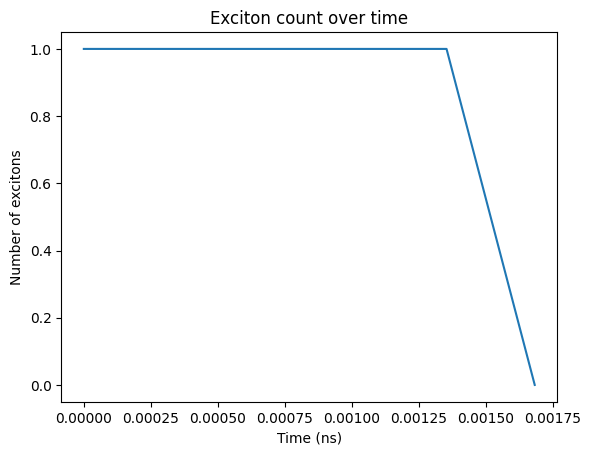

In [206]:
traj = results[0]
times = traj[0]
snapshots = traj[1]
n_excitons = [len(snap) for snap in snapshots]

import matplotlib.pyplot as plt
plt.plot(times, n_excitons)
plt.xlabel("Time (ns)")
plt.ylabel("Number of excitons")
plt.title("Exciton count over time")
plt.show()

In [ ]:
#from excipy.examples.test1.submit import run_kmc_PBC_parallel
from excipy.kmc import run_kmc_PBC_parallel

all_runs = run_kmc_PBC_parallel(
    num_trajectories=64,
    processors=32,
    system=molecules,  # mol,
    neighbors=neighbors,
    num_excitons=1,  # if exc_list is not None, then ignored!
    # exc_list=add_exciton_random(molecules, NUM_EXC), # add_exciton_random(mol, NUM_EXC),
    coupling_matrix=V_csr / 1.35,
    overlap=1.22,
    decay_rate=4 * 1e9,
    annih_rate=1e15,
    max_time=1.2e-9,
    max_steps=900000,
    box=box,  # (a, b, c),
    verbose=True,
)

AttributeError: 'tuple' object has no attribute 'get_center_of_mass'

In [ ]:
start = time()

Vol = (
    super_cell.get_volume() * 1e-12
)  # converting micrometr cube, match with experimental units

print("Volume: {:.3f} nm^3".format(Vol * 1e9))
print(
    "Lattice parameters [Å]:\n",
    cell.get_cell()[0],
    "\n",
    cell.get_cell()[1],
    "\n",
    cell.get_cell()[2],
    "\n",
)
t = time() - start
print(
    "Time for molecule separation: {} min {:.2f} s".format(
        int(t / 60), t - int(t / 60) * 60
    )
)

exc_conc = 370000  # excitons per micrometr cube, taken from experimental data

Vol = (
    super_cell.get_volume() * 1e-12
)  # converting micrometr cube, match with experimental units
print("Volume: {:.3f} nm^3".format(Vol * 1e9))
NUM_EXC = int(exc_conc * Vol) + 10
print(
    "Number of excitons required for {} value in experiment: {}".format(
        exc_conc, int(exc_conc * Vol)
    )
)

Volume: 251.602 nm^3
Lattice parameters [Å]:
 [6.3115 0.     0.    ] 
 [0.     6.3115 0.    ] 
 [0.     0.     6.3161] 

Time for molecule separation: 0 min 0.00 s
Volume: 251.602 nm^3
Number of excitons required for 370000 value in experiment: 0


In [141]:
a = super_cell.get_cell()[0, 0]
b = super_cell.get_cell()[1, 1]
c = super_cell.get_cell()[2, 2]


coords = []
for molecule in molecules:
    coords.append(molecule.get_center_of_mass())
print(len(coords))

# mol = add_tdm(mu0, mol) # add rotated TDM to each molecule in the system

# neighbors, V = TDM_couplings_fast_PBC(molecules=mol, cutoff=20, box=(a,b,c))

# V_csr1 = csr_matrix(V, dtype=V.dtype)      # keeps only the non–zero entries
# print("dense aray :", V.shape, "   bytes:", V.nbytes / 1e6, "MB")
# print("sparse array   :", V.nnz,       "   bytes:", V.data.nbytes / 1e6, "MB")

AttributeError: 'tuple' object has no attribute 'get_center_of_mass'

In [ ]:
from excipy.analysis import load_output_light

data = load_output_light("output.h5")

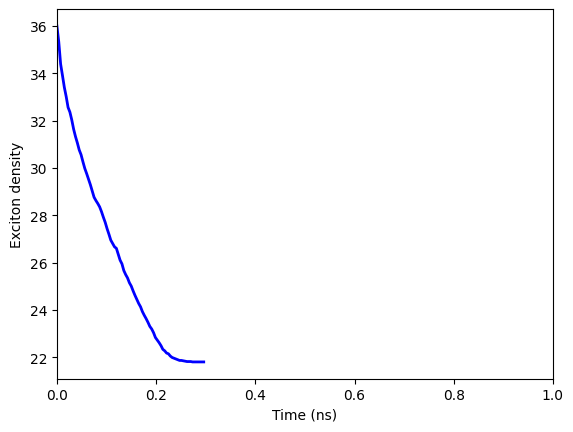

In [ ]:
from excipy.analysis import plot_average_exciton_population

plot_average_exciton_population(data, num_bins=80, x0=0, xf=0.8)
plt.xlim(0, 1)
# plt.ylim(0.001,46)
plt.savefig("exciton_density.png", bbox_inches="tight")

In [ ]:
t, exc = np.loadtxt("density.dat")
plt.figure(figsize=(5, 4))
plt.plot(t, exc, "b", linewidth=2)
plt.xlim(0, 1)
# plt.ylim(0,40)

NameError: name 'np' is not defined

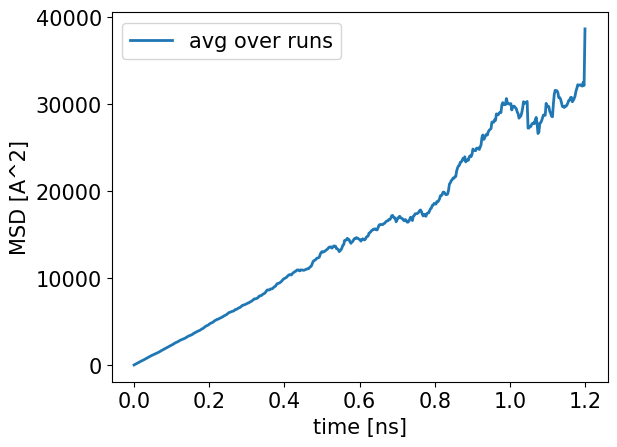

In [ ]:
t_grid, msd_avg = np.loadtxt("msd_avg.dat")
plt.plot(t_grid, msd_avg, lw=2, label="avg over runs")
plt.legend()
# plt.xlim(0, 0.2)
plt.ylabel("MSD [A^2]")
plt.xlabel("time [ns]")
plt.savefig("MSD_avg_over_runs.png", bbox_inches="tight")
plt.show()

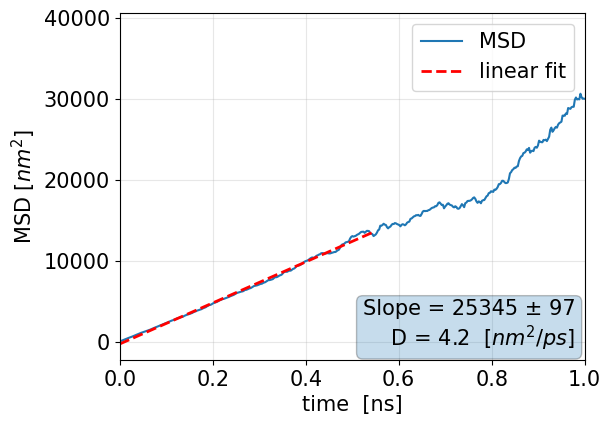

In [ ]:
from excipy.analysis import plot_msd_with_fit

plot_msd_with_fit(t_grid, msd_avg, t_min=0, t_max=0.55)
plt.xlim(0, 1)
plt.savefig("MSD_final.png", bbox_inches="tight")

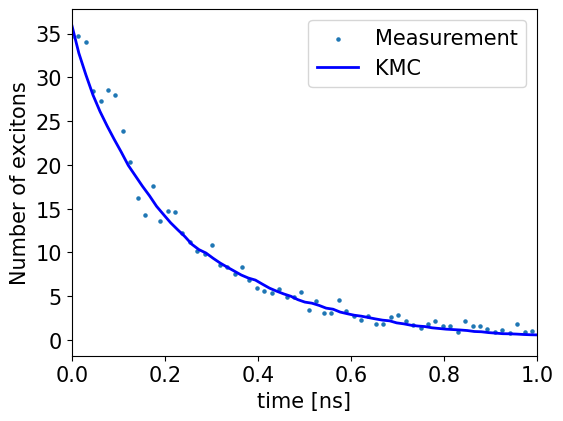

In [ ]:
t, exc = np.loadtxt("density.dat")
ex = np.loadtxt("KS_16_45deg_DL10000au_Bereich1_time.dat", unpack=True)
plt.figure(figsize=(6, 4.5))
plt.scatter(
    ex[0] - 2.93, ex[1] / max(ex[1]) * 36, linewidth=1, s=5, label="Measurement"
)
plt.plot(t, exc, "b", linewidth=2, label="KMC")
plt.xlim(0, 1)
plt.xlabel("time [ns]")
plt.ylabel("Number of excitons")
plt.legend()
plt.savefig("exciton_density.png", bbox_inches="tight")